In [14]:
import tensorflow as tf
from keras.datasets import mnist
from pyforest import *
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten,BatchNormalization
from keras.optimizers import SGD
import cv2
from PIL import Image
import glob
from tqdm import tqdm


from matplotlib import style
import seaborn as sns
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from keras.preprocessing.image import ImageDataGenerator

from keras import backend as K
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop

import random as rn

import os                   
from random import shuffle  
from zipfile import ZipFile

np.random.seed(42)
rn.seed(42)
tf.set_random_seed(42)

In [15]:
shape = (80,80)
b_and_w = True
num_classes = 5

In [16]:
def make_train_data(x, y, flower_type, DIR, bnw, shape):
    for img in tqdm(os.listdir(DIR)):
        label=flower_type
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        try:
            if bnw:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, shape)

            x.append(np.array(img))
            y.append(str(label))
        except:
            continue

In [17]:
def datasender(black_and_white=True,shape=(80,80)):
    x=[]
    y=[]
    flowers = ['daisy','sunflower','tulip','dandelion','rose']
    _dir = 'd/flowers/'
    for f in flowers:
        make_train_data(x,y,f,_dir+f,black_and_white,shape)
    return x,y

In [18]:
X,Y = datasender(black_and_white=b_and_w,shape=shape)

100%|██████████| 784/784 [00:01<00:00, 527.48it/s]


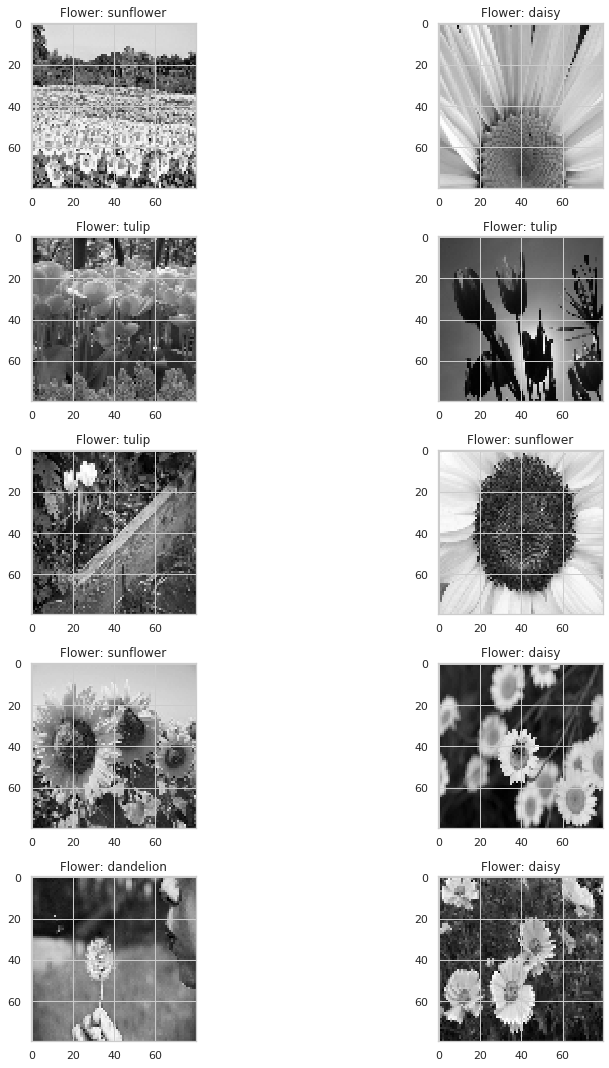

In [19]:

fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Y))
        ax[i,j].imshow(X[l],cmap='gray')
        ax[i,j].set_title('Flower: '+Y[l])
        
plt.tight_layout()

In [20]:
le=LabelEncoder()
y=le.fit_transform(Y)
y=keras.utils.to_categorical(y,5)
x=np.array(X)
x=x/255
if b_and_w:
    x = np.reshape(x,[x.shape[0],x.shape[1],x.shape[2],1])

In [22]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.1,random_state=42)

In [23]:
def plot(history,loss,accuracy):
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['Training', 'Validation'], loc='best')
    plt.show()

    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['Training', 'Validation'], loc='best')
    plt.show()

    print()
    print(f'Test loss: {loss:.3}')
    print(f'Test accuracy: {accuracy:.3}')

In [24]:
def check_mis_corr(pred_flower,x_test,black_and_white=True):
    i=0
    corr_class=[]
    mis_class=[]

    for i in range(len(y_test)):
        if(np.argmax(y_test[i])==pred_flower[i]):
            corr_class.append(i)
        if(len(corr_class)==8):
            break

    i=0
    for i in range(len(y_test)):
        if(not np.argmax(y_test[i])==pred_flower[i]):
            mis_class.append(i)
        if(len(mis_class)==8):
            break
    
    print("\n\nCorrectly Classified Images")
    
    if black_and_white:
        x_test = np.reshape(x_test,[1081,80,80])
    
    count=0
    fig,ax=plt.subplots(4,2)
    fig.set_size_inches(15,15)
    for i in range (4):
        for j in range (2):
            ax[i,j].imshow(x_test[corr_class[count]])
            ax[i,j].set_title("Predicted : "+str(le.inverse_transform([pred_flower[corr_class[count]]]))+"\n"+"Actual :"+str(le.inverse_transform([np.argmax([y_test[corr_class[count]]])])))
            plt.tight_layout()
            count+=1
    plt.show()
    print("\n\nMisclassified Images\n\n")
        
    count=0
    fig,ax=plt.subplots(4,2)
    fig.set_size_inches(15,15)
    for i in range (4):
        for j in range (2):
            ax[i,j].imshow(x_test[mis_class[count]])
            ax[i,j].set_title("Predicted :"+str(le.inverse_transform([pred_flower[mis_class[count]]]))+"\n"+"Actual :"+str(le.inverse_transform([np.argmax([y_test[mis_class[count]]])])))
            plt.tight_layout()
            count+=1

In [59]:
def create(shape):
    model = Sequential()
    model.add(Conv2D(filters = 16, kernel_size=(5,5), padding='Same', activation='relu', input_shape = shape))
    model.add(MaxPooling2D())
    model.add(Dropout(0.5))
    model.add(Conv2D(32, (4, 4), padding='Same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.3))
    model.add(Conv2D(64, (3, 3),padding='Same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [26]:
def create2(shape):
    model = Sequential()
    model.add(Conv2D(filters = 16, kernel_size=(5,5), padding='Same', activation='relu', input_shape = shape))
    model.add(MaxPooling2D())
    model.add(Conv2D(32, (4, 4), padding='Same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3),padding='Same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [27]:
def create3(shape):
    model = Sequential()
    model.add(Conv2D(filters = 16, kernel_size=(5,5), padding='Same', activation='relu', input_shape = shape))
    model.add(MaxPooling2D())
    model.add(Conv2D(32, (4, 4), padding='Same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3),padding='Same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(BatchNormalization())
    model.add(Conv2D(96, (3, 3),padding='Same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [28]:
def evaluate(model,batch_size=128,epochs=20):
    model.summary()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=.2)
    loss, accuracy  = model.evaluate(x_test, y_test, verbose=True,batch_size=batch_size)
    plot(history,loss,accuracy)

In [29]:
batch_size = 128
epochs = 50






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 80, 80, 16)        416       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 40, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 40, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 32)        8224      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 20, 32)        0         


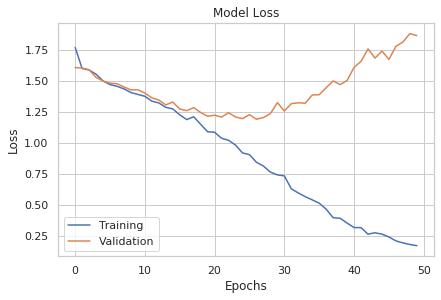

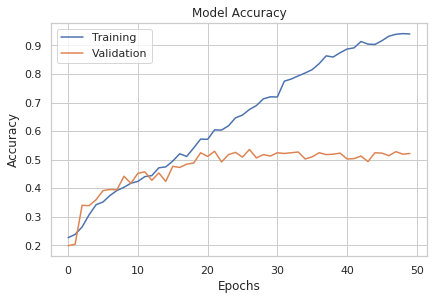


Test loss: 1.88
Test accuracy: 0.513


In [30]:
input_shape = (shape[0],shape[0],1)
model = create(input_shape)
evaluate(model,batch_size=batch_size,epochs=epochs)

In [31]:
pred=model.predict(x_test)
pred_flower=np.argmax(pred,axis=1)
check_mis_corr(pred_flower,x_test)



Correctly Classified Images


ValueError: cannot reshape array of size 2771200 into shape (1081,80,80)

# Second Model

In [32]:
batch_size = 128
epochs = 50


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 80, 80, 16)        416       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 40, 40, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 40, 40, 32)        8224      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 20, 20, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 20, 32)        128       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 10, 10, 64)      

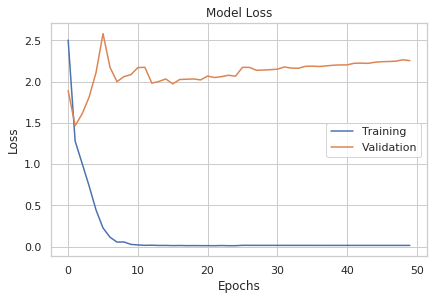

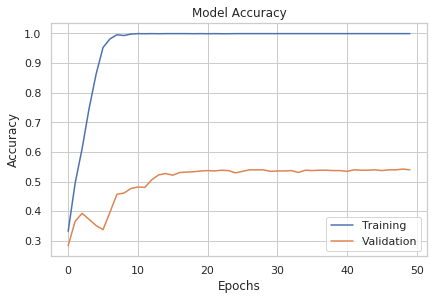


Test loss: 2.28
Test accuracy: 0.533


In [33]:
input_shape = (shape[0],shape[0],1)
model2 = create2(input_shape)
evaluate(model2,batch_size=batch_size,epochs=epochs)

In [ ]:
pred=model2.predict(x_test)
pred_flower=np.argmax(pred,axis=1)
check_mis_corr(pred_flower,x_test)

# Third Model

In [34]:
batch_size = 128
epochs = 50

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 80, 80, 16)        416       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 40, 40, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 40, 40, 32)        8224      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 20, 20, 32)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 20, 20, 32)        128       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 10, 10, 64)       

3112/3112 [==============================] - 4s 1ms/step - loss: 0.0117 - acc: 0.9990 - val_loss: 1.9746 - val_acc: 0.5540
Epoch 45/50
3112/3112 [==============================] - 4s 1ms/step - loss: 0.0118 - acc: 0.9990 - val_loss: 2.0031 - val_acc: 0.5488
Epoch 46/50
3112/3112 [==============================] - 4s 1ms/step - loss: 0.0114 - acc: 0.9990 - val_loss: 1.9725 - val_acc: 0.5540
Epoch 47/50
3112/3112 [==============================] - 4s 1ms/step - loss: 0.0111 - acc: 0.9990 - val_loss: 1.9711 - val_acc: 0.5488
Epoch 48/50
3112/3112 [==============================] - 4s 1ms/step - loss: 0.0115 - acc: 0.9987 - val_loss: 1.9901 - val_acc: 0.5527
Epoch 49/50
3112/3112 [==============================] - 4s 1ms/step - loss: 0.0113 - acc: 0.9990 - val_loss: 1.9960 - val_acc: 0.5488
Epoch 50/50
433/433 [==============================] - 0s 327us/step


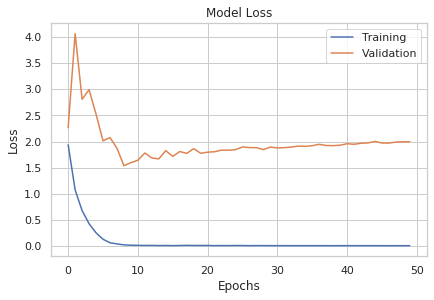

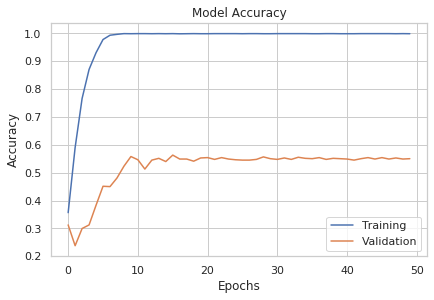


Test loss: 2.2
Test accuracy: 0.543


In [35]:
input_shape = (shape[0],shape[0],1)
model3 = create3(input_shape)
evaluate(model3,batch_size=batch_size,epochs=epochs)

In [ ]:
pred=model3.predict(x_test)
pred_flower=np.argmax(pred,axis=1)
check_mis_corr(pred_flower,x_test)

# Now with Color Images

In [36]:
X,Y = datasender(black_and_white=False,shape=shape)

100%|██████████| 784/784 [00:01<00:00, 558.50it/s]


In [37]:
le=LabelEncoder()
y=le.fit_transform(Y)
y=keras.utils.to_categorical(y,5)
x=np.array(X)
x=x/255

In [60]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.1,random_state=42)

In [61]:
batch_size = 128
epochs = 50

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 80, 80, 16)        1216      
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 40, 40, 16)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 40, 40, 16)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 40, 40, 32)        8224      
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 20, 20, 32)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 20, 20, 64)      

3112/3112 [==============================] - 5s 2ms/step - loss: 0.1583 - acc: 0.9470 - val_loss: 1.2421 - val_acc: 0.6774
Epoch 47/50
3112/3112 [==============================] - 5s 2ms/step - loss: 0.1383 - acc: 0.9553 - val_loss: 1.2924 - val_acc: 0.6517
Epoch 48/50
3112/3112 [==============================] - 5s 2ms/step - loss: 0.1237 - acc: 0.9602 - val_loss: 1.3416 - val_acc: 0.6697
Epoch 49/50
3112/3112 [==============================] - 5s 2ms/step - loss: 0.1400 - acc: 0.9524 - val_loss: 1.2244 - val_acc: 0.6517
Epoch 50/50
433/433 [==============================] - 0s 394us/step


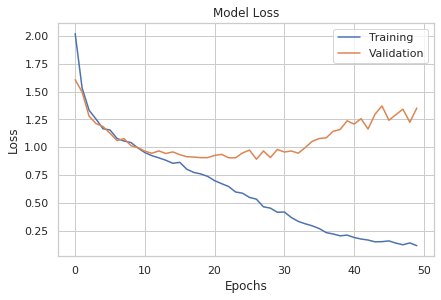

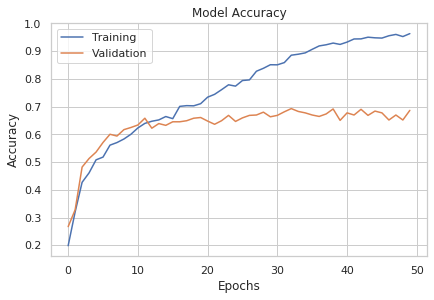


Test loss: 1.44
Test accuracy: 0.665


In [62]:
input_shape = (shape[0],shape[0],3)
model = create(input_shape)
evaluate(model,batch_size=batch_size,epochs=epochs)



Correctly Classified Images


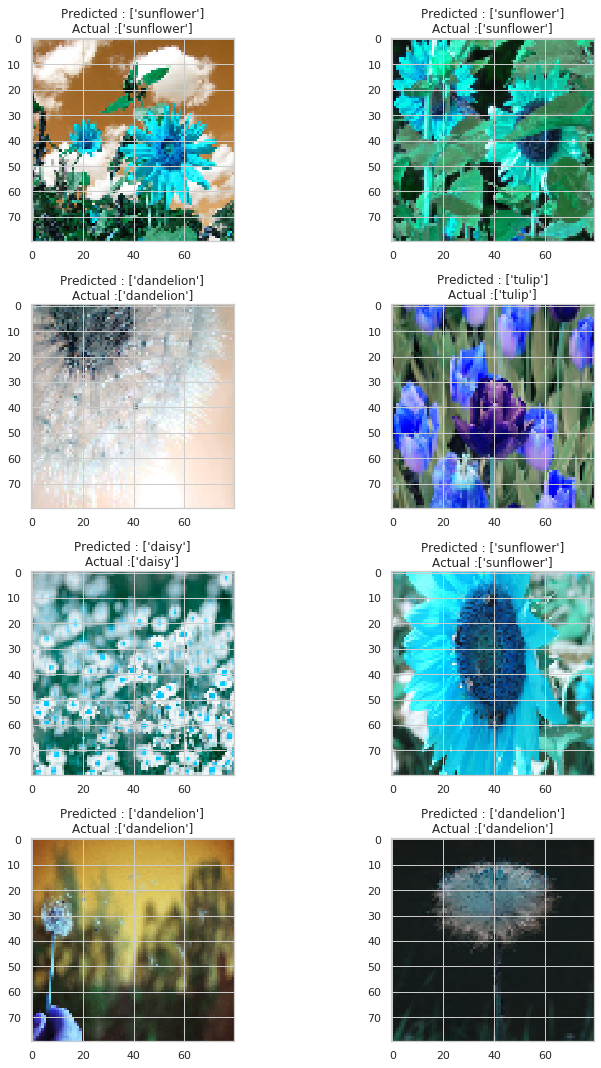



Misclassified Images




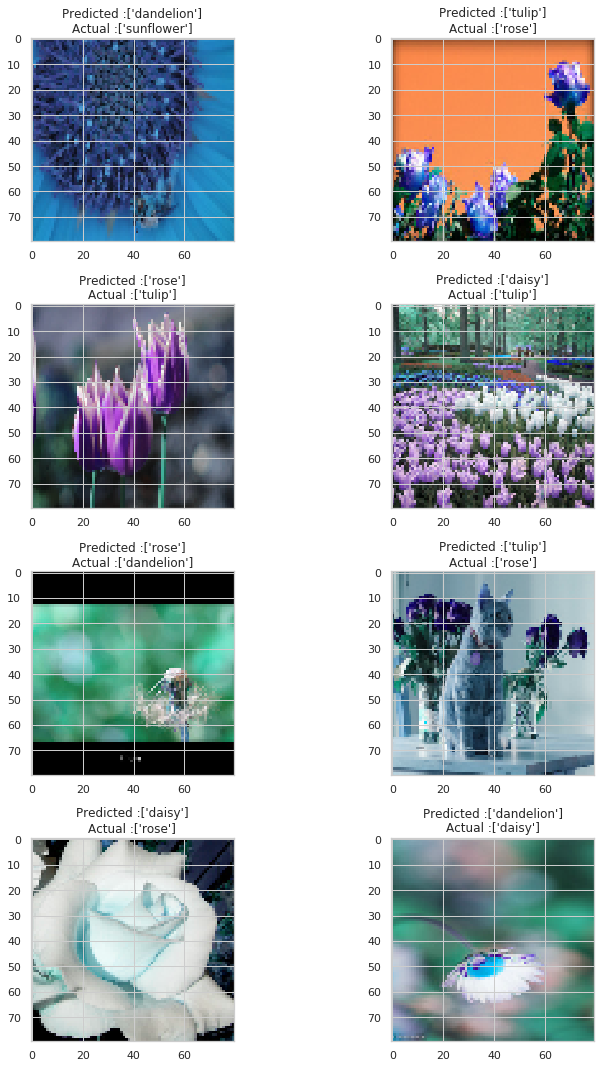

In [49]:
pred=model.predict(x_test)
pred_flower=np.argmax(pred,axis=1)
check_mis_corr(pred_flower,x_test,black_and_white=False)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 80, 80, 16)        1216      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 40, 40, 16)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 40, 40, 32)        8224      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 20, 20, 32)        0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 20, 20, 32)        128       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 20, 20, 64)        18496     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 10, 10, 64)       

Epoch 47/50
3112/3112 [==============================] - 5s 2ms/step - loss: 0.0023 - acc: 0.9987 - val_loss: 1.4583 - val_acc: 0.6812
Epoch 48/50
3112/3112 [==============================] - 5s 2ms/step - loss: 0.0019 - acc: 0.9987 - val_loss: 1.4758 - val_acc: 0.6774
Epoch 49/50
3112/3112 [==============================] - 5s 2ms/step - loss: 0.0017 - acc: 0.9987 - val_loss: 1.4607 - val_acc: 0.6799
Epoch 50/50
433/433 [==============================] - 0s 415us/step


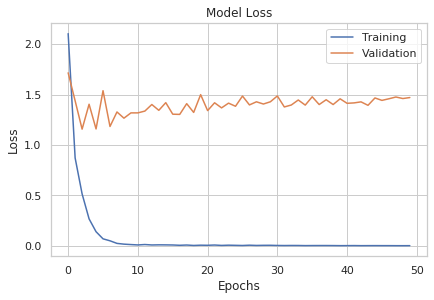

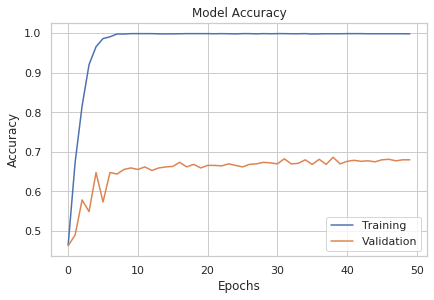


Test loss: 1.64
Test accuracy: 0.674


In [50]:
batch_size = 128
epochs = 50
input_shape = (shape[0],shape[0],3)
model2 = create2(input_shape)
evaluate(model2,batch_size=batch_size,epochs=epochs)



Correctly Classified Images


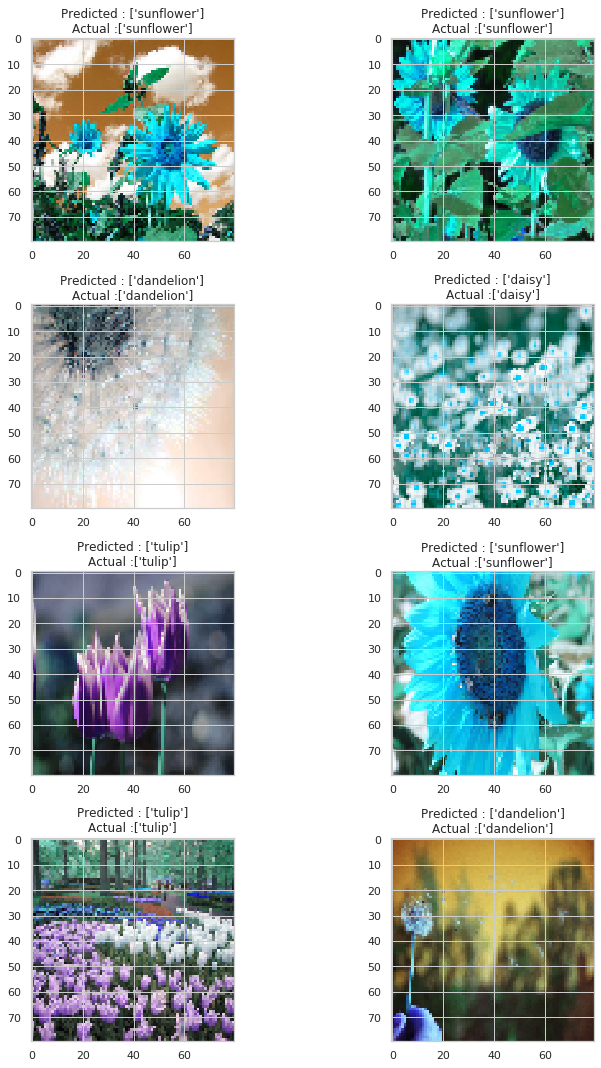



Misclassified Images




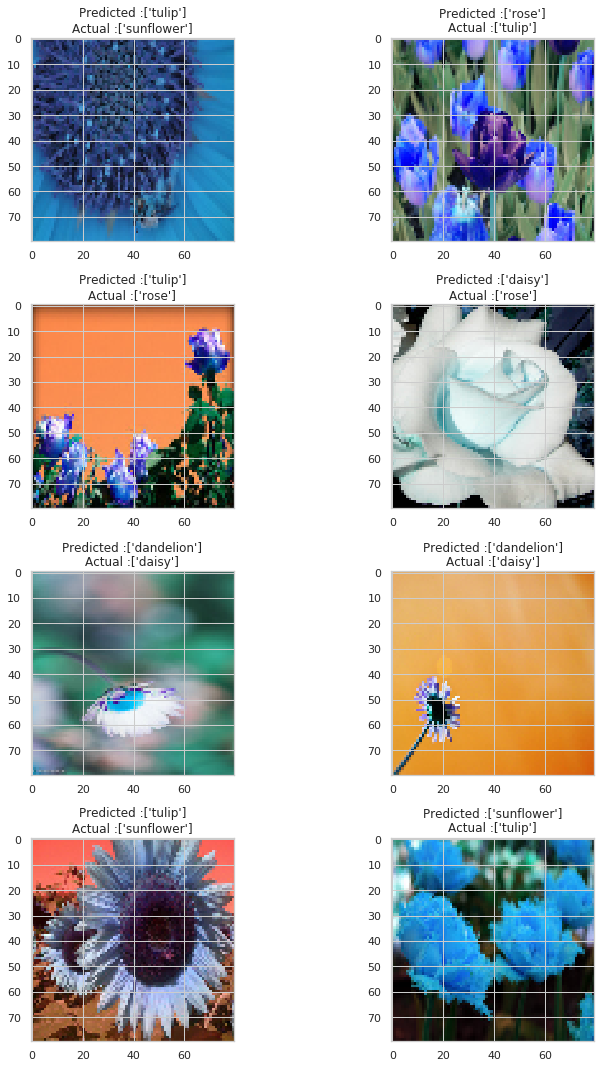

In [51]:
pred=model2.predict(x_test)
pred_flower=np.argmax(pred,axis=1)
check_mis_corr(pred_flower,x_test,black_and_white=False)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 80, 80, 16)        1216      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 40, 40, 16)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 40, 40, 32)        8224      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 20, 20, 32)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 20, 20, 32)        128       
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 20, 20, 64)        18496     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 10, 10, 64)       

3112/3112 [==============================] - 5s 2ms/step - loss: 0.0073 - acc: 0.9990 - val_loss: 1.3478 - val_acc: 0.7057
Epoch 45/50
3112/3112 [==============================] - 5s 2ms/step - loss: 0.0081 - acc: 0.9987 - val_loss: 1.3275 - val_acc: 0.7044
Epoch 46/50
3112/3112 [==============================] - 5s 2ms/step - loss: 0.0079 - acc: 0.9987 - val_loss: 1.3489 - val_acc: 0.7095
Epoch 47/50
3112/3112 [==============================] - 5s 2ms/step - loss: 0.0082 - acc: 0.9987 - val_loss: 1.4786 - val_acc: 0.6799
Epoch 48/50
3112/3112 [==============================] - 5s 2ms/step - loss: 0.0076 - acc: 0.9987 - val_loss: 1.3891 - val_acc: 0.6954
Epoch 49/50
3112/3112 [==============================] - 5s 2ms/step - loss: 0.0068 - acc: 0.9987 - val_loss: 1.3702 - val_acc: 0.6941
Epoch 50/50
433/433 [==============================] - 0s 432us/step


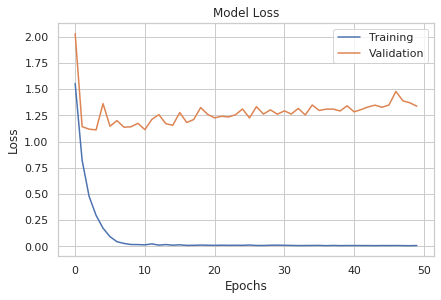

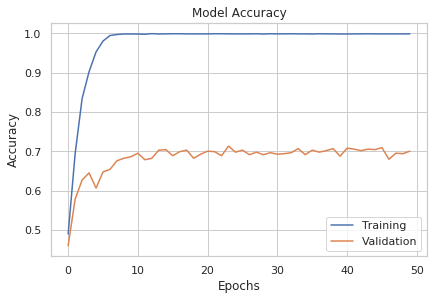


Test loss: 1.46
Test accuracy: 0.681


In [52]:
batch_size = 128
epochs = 50
input_shape = (shape[0],shape[0],3)
model3 = create3(input_shape)
evaluate(model3,batch_size=batch_size,epochs=epochs)



Correctly Classified Images


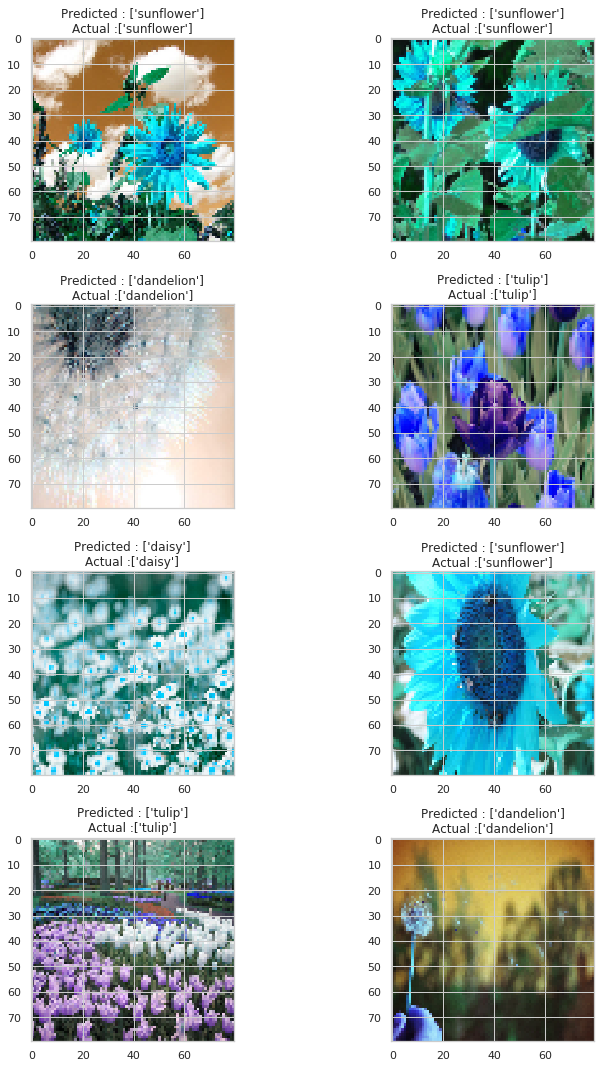



Misclassified Images




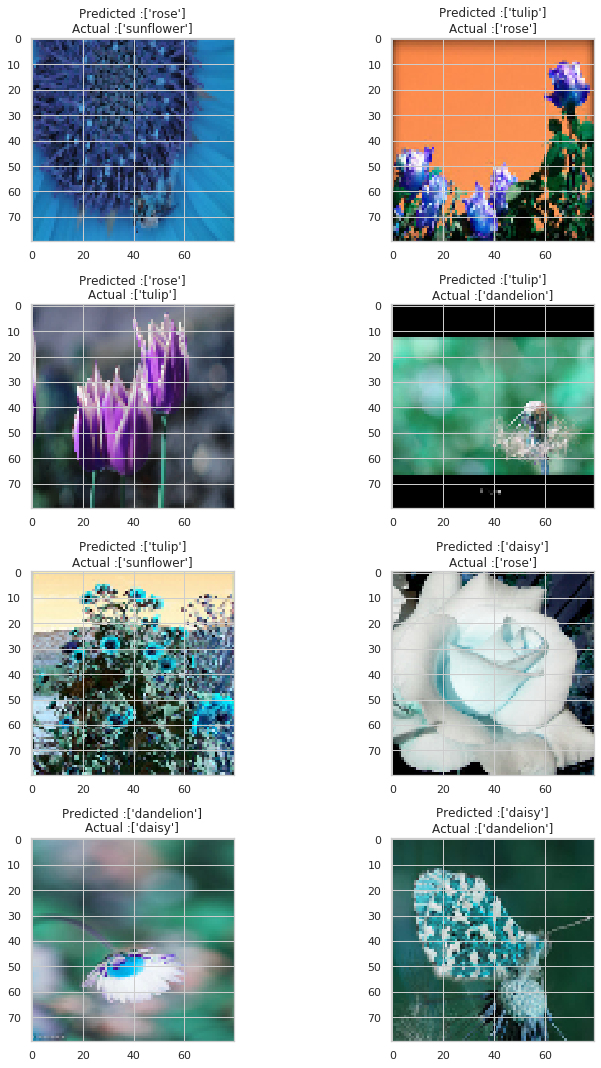

In [53]:
pred=model3.predict(x_test)
pred_flower=np.argmax(pred,axis=1)
check_mis_corr(pred_flower,x_test,black_and_white=False)